In [1]:
from __future__ import print_function
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import itertools

import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import skimage.io as io
import pickle as pk
import copy

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
class ArtistDataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224), style = "Impressionism"):
        super(ArtistDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.style = style
        self.images_dir = os.path.join(root_dir, "%s/*.jpg" % style)
        if os.path.exists('/images/%s.pkl' % style):
            with open('/images/%s.pkl' % style, 'rb') as file:
                self.imgs = pk.load(file)
        else:
            self.imgs = io.ImageCollection(self.images_dir)
        if mode == 'train':
            self.imgs = self.imgs[:400]
        else:
            self.imgs = self.imgs[400:500]
    def __len__(self):
        return len(self.imgs)
    def __repr__(self):
        return "ArtistDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        #img = np.moveaxis(self.imgs[idx], [0,1,2], [1,2,0])
        img = Image.fromarray(self.imgs[idx])
        transform = tv.transforms.Compose([
        tv.transforms.Resize(self.image_size),
        #tv.transforms.RandomCrop(self.image_size),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
        ])
        x = transform(img)
        return x, x

In [5]:
class LandDataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224), style = "city"):
        super(LandDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.style = style
        self.images_dir = os.path.join(root_dir, "%s/*.jpg" % style)
        if os.path.exists('%s.pkl' % style):
            with open('%s.pkl' % style, 'rb') as file:
                self.imgs = pk.load(file)
        else:
            self.imgs = io.ImageCollection(self.images_dir)
        if mode == 'train':
            self.imgs = self.imgs[:400]
        else:
            self.imgs = self.imgs[400:500]
    def __len__(self):
        return len(self.imgs)
    def __repr__(self):
        return "LandDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        #img = np.moveaxis(self.imgs[idx], [0,1,2], [1,2,0])
        img = Image.fromarray(self.imgs[idx])
        transform = tv.transforms.Compose([
        tv.transforms.Resize(self.image_size),
        #tv.transforms.RandomCrop(self.image_size),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
        ])
        x = transform(img)
        return x, x

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [7]:
artist_dataset_root_dir = '/datasets/ee285f-public/wikiart/wikiart/'
styles = ['Impressionism', 'Expressionism', 'Ukiyo_e', 'Baroque']
land_dataset_root_dir = '/datasets/ee285f-public/flickr_landscape/'
lands = ['city', 'mountain', 'forest', 'lake', 'ocean']

In [8]:
train_set_A = LandDataset(land_dataset_root_dir, style=lands[1])
train_set_B = ArtistDataset(artist_dataset_root_dir, style=styles[2])
val_set_A = LandDataset(land_dataset_root_dir, mode='val', style=lands[1])
val_set_B = LandDataset(artist_dataset_root_dir, mode='val', style=styles[2])

In [9]:
len(train_set_A)

400

In [10]:
len(train_set_B)

400

In [11]:
len(val_set_A)

100

In [12]:
len(val_set_B)

100

In [13]:
x, _ = val_set_B[40]

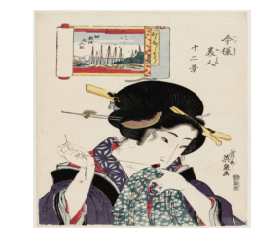

In [14]:
myimshow(x)

In [15]:
import nntools as nt
class Generator(nt.NeuralNetwork):
    def __init__(self, D, C=64):
        assert(D%2 == 0)
        assert(D>=4)
        super(Generator, self).__init__()
        import math
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        nn.init.kaiming_normal_(self.conv[0].weight.data)
        self.bn = nn.ModuleList()
        for k in range(D):
            if k < D/2:
                self.conv.append(nn.Conv2d(C, C, 3, dilation=int(math.pow(2,k)), padding=int(math.pow(2,k))))
            else:
                self.conv.append(nn.Conv2d(C, C, 3, dilation=int(math.pow(2,5-k)), padding=int(math.pow(2,5-k))))
            nn.init.kaiming_normal_(self.conv[k+1].weight.data)
            self.bn.append(nn.BatchNorm2d(C, C))
            nn.init.constant_(self.bn[k].weight.data, 1.25*np.sqrt(C))
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        #nn.init.kaiming_normal_(self.conv[D+1].weight.data)
        
    def forward(self, x):
        import math
        features = []
        D = self.D
        torch.backends.cudnn.benchmark=True
        h = F.relu(self.conv[0](x))
        features.append(h)
        for k in range(D):
            if k < D//2-1:
                h = F.relu(self.bn[k](self.conv[k+1](h)))
                features.append(h)
            elif k == D//2-1:
                h = F.relu(self.bn[k](self.conv[k+1](h)))
            elif k == D/2:
                h = F.relu(self.bn[k](self.conv[k+1](h)))
                h = (h + features[D-k-1])/math.sqrt(2)
            else:
                h = F.relu(self.bn[k](self.conv[k+1](h)))
                h = (h + features[D-k-1])/math.sqrt(2)
        h = (h + features[0])/math.sqrt(2)
        y = self.conv[D+1](h) + x
        torch.backends.cudnn.benchmark=False
        y = F.tanh(y)
        return y
    
    def criterion(self, y, d):
        pass

In [16]:
class Discriminator(nt.NeuralNetwork):
    # initializers
    def __init__(self, C=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, C, 4, 2, 1)
        self.conv2 = nn.Conv2d(C, C * 2, 4, 2, 1)
        self.conv2_norm = nn.InstanceNorm2d(C * 2)
        self.conv3 = nn.Conv2d(C * 2, C * 4, 4, 2, 1)
        self.conv3_norm = nn.InstanceNorm2d(C * 4)
        self.conv4 = nn.Conv2d(C * 4, C * 8, 4, 1, 1)
        self.conv4_norm = nn.InstanceNorm2d(C * 8)
        self.conv5 = nn.Conv2d(C * 8, 1, 4, 1, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_norm(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_norm(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_norm(self.conv4(x)), 0.2)
        x = self.conv5(x)
        return x
    
    def criterion(self, y, d):
        pass

In [17]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
class CycleGANStatsManager(nt.StatsManager):
    def __init__(self):
        super(CycleGANStatsManager, self).__init__()
    def init(self):
        super(CycleGANStatsManager, self).init()
        self.running_DA_loss = 0
        self.running_DB_loss = 0
        self.num = 0
    def accumulate(self, loss, DA, DB, x=None, y=None, d=None):
        super(CycleGANStatsManager, self).accumulate(loss, DA, DB, x, y, d)
        self.running_DA_loss += DA
        self.running_DB_loss += DB
        self.num += 1
    def summarize(self):
        loss = super(CycleGANStatsManager, self).summarize()
        DA_loss = self.running_DA_loss / self.num
        DB_loss = self.running_DB_loss / self.num
        return {'Gloss': loss, 'DALoss': DA_loss, 'DBLoss': DB_loss}

In [18]:
lrG = 0.0002
lrD = 0.0002
beta1 = 0.5
beta2 = 0.999
gnetA = Generator(D=6)
gnetB = Generator(D=6)
dnetA = Discriminator()
dnetB = Discriminator()
dnetA.weight_init(mean=0.0, std=0.02)
dnetB.weight_init(mean=0.0, std=0.02)
gnetA = gnetA.to(device)
gnetB = gnetB.to(device)
dnetA = dnetA.to(device)
dnetB = dnetB.to(device)
G_optimizer = optim.Adam(itertools.chain(gnetA.parameters(), gnetB.parameters()), lr=1.7448878713438587e-19, betas=(beta1, beta2))
D_A_optimizer = optim.Adam(dnetA.parameters(), lr=1.7448878713438587e-19, betas=(beta1, beta2))
D_B_optimizer = optim.Adam(dnetB.parameters(), lr=1.7448878713438587e-19, betas=(beta1, beta2))
stats_manager = CycleGANStatsManager()
exp_uki = nt.Experiment(gnetA=gnetA, gnetB=gnetB, dnetA=dnetA, dnetB=dnetB, train_set_A=train_set_A, 
                     train_set_B=train_set_B, val_set_A=val_set_A, val_set_B=val_set_B, G_optimizer=G_optimizer, D_A_optimizer=D_A_optimizer, 
                     D_B_optimizer=D_B_optimizer, stats_manager=stats_manager, output_dir="ukiyo_e", batch_size=4, 
                     perform_validation_during_training=True)

In [19]:
def plot(exp, fig, axes, realA, visu_rate=2):
    pic = realA
    from PIL import Image
    img2 = np.moveaxis(pic.numpy(), [0,1,2], [2,0,1])
    img2 = (img2+1)*255/2
    im2 = Image.fromarray(np.uint8(img2))
    im2.save("originalA.jpg")
    
    
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        fakeB = exp.gnetA(realA[np.newaxis].to(exp.gnetA.device))[0]
    img = np.moveaxis(fakeB.detach().cpu().numpy(), [0,1,2], [2,0,1])
    img = (img+1)*255/2
    im = Image.fromarray(np.uint8(img))
    im.save("output.jpg")
    
    class Arg: pass
    arg = Arg()
    arg.rgb='originalA.jpg'
    arg.gpu_fraction=1.0
    arg.rgb_folder=None
    import inference
    i_ori = inference.main(arg)
    
    arg = Arg()
    arg.rgb='output.jpg'
    arg.gpu_fraction=1.0
    arg.rgb_folder=None
    i_fake = inference.main(arg)

        
    axes[0][0].clear()
    axes[0][1].clear()
    axes[2][0].clear()
    axes[2][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(realA, ax=axes[0][0])
    myimshow(fakeB, ax=axes[0][1])
    
    axes[1][0].imshow(i_ori)
    axes[1][1].imshow(i_fake)
    axes[0][0].set_title('Real A image')
    axes[0][1].set_title('Generated B image')
    
    axes[2][0].set_title('Loss for Cycle A')
    axes[2][1].set_title('Loss for Cycle B')
    
    axes[1][0].set_title('Salient Objective Detection for Real A')
    axes[1][1].set_title('Salient Objective Detection for Generated B')
    
    axes[0][0].axis('off')
    axes[0][1].axis('off')
    axes[2][0].plot([exp.history[k][0]['DALoss'] for k in range(exp.epoch)],label="training DAloss")
    axes[2][1].plot([exp.history[k][0]['DBLoss'] for k in range(exp.epoch)],label="training DBloss")
    plt.tight_layout()
    fig.canvas.draw()

Start/Continue training from epoch 150


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Restoring parameters from ./salience_model/model.ckpt-200
INFO:tensorflow:Restoring parameters from ./salience_model/model.ckpt-200
Finish training for 150 epochs


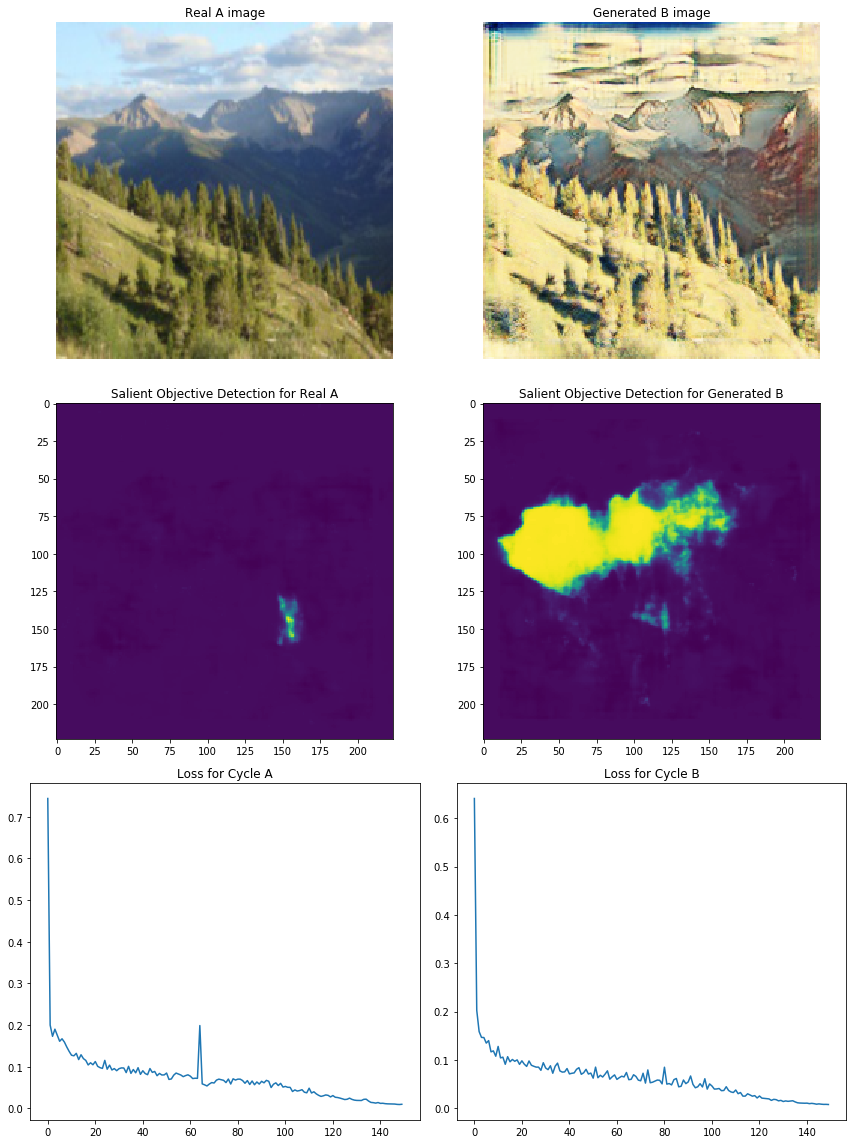

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12,16))
exp_uki.run(num_epochs=150, decay_epoch=100, lrG=lrG, lrD=lrD, plot=lambda exp: plot(exp, fig=fig, axes=axes, realA=val_set_A[20][0]))

In [21]:
import time
s = time.time()
fake = exp_uki.gnetA(val_set_A[20][0][np.newaxis].cuda())
print(time.time()-s)

0.03961062431335449


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
